In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)


nombre de neurones taille 1: 47
sub_pxl_map
nb neurones couche 2 : 46
nombre de neurones couche 1 & 2: 94


/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/Users/oliviermanette/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = 

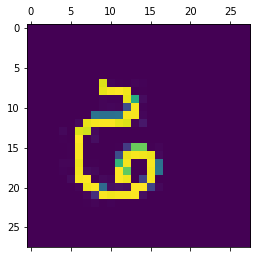

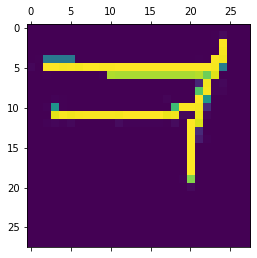

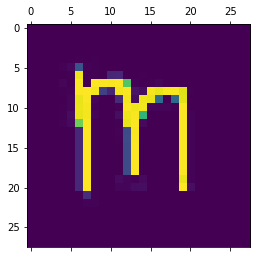

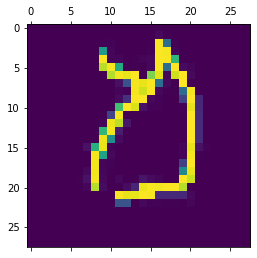

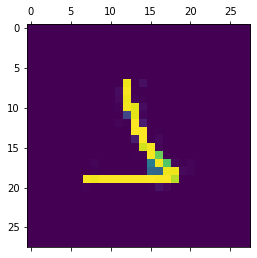

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(8)

{'_id': 8,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 1,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [55, 56, 62],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 12, 'y': 11}, 'matrix_width': 1}}

In [4]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(9)

{'_id': 9,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 1,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [56],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 13, 'y': 11}, 'matrix_width': 1}}

In [5]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(10)

{'_id': 10,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 1,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [57, 58, 59, 64],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 7, 'y': 12}, 'matrix_width': 1}}

In [6]:
sbrain.nnet[0].nrn_pxl_map[12][13]

0.0

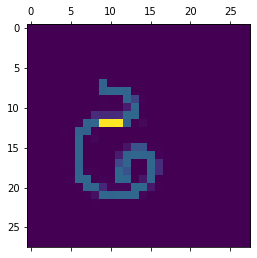

In [20]:
sbrain.nnet[0].show_receptive_field_id(61)

In [8]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(52)

{'_id': 52,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 2,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [3.0, 4.0, 5.0],
  'post_synaptique': [],
  'lateral_connexion': [51, 52, 53],
  'weights': {53: 1, 52: 1, 51: 1}},
 'meta': {'center': {'x': 12, 'y': 8},
  'matrix_width': 3,
  'sub_pxl_map': array([[0., 0., 0.],
         [0., 0., 0.],
         [3., 4., 5.]]),
  'pxl_coord': [[12, 8], [11, 8], [10, 8]],
  'glbl_prm': {'cg': {'x': 11.0, 'y': 8.0}, 'u_axis': {'x': -1.0, 'y': -0.0}}}}

In [9]:
sbrain.nnet[0].nrn_pxl_map[12][7]

10.0

In [10]:
sbrain.nnet[0].nrn_pxl_map

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0

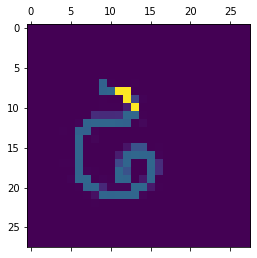

In [11]:
sbrain.nnet[0].show_receptive_field_id(54)